# True vs Model Labels

In [114]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from sklearn import linear_model
from recourse_methods import mrmc_method
from core import recourse_iterator
from data import data_adapter as da
from data import data_preprocessor as dp
from models import model_utils
from core import utils
from visualize.two_d_plots import Display2DPaths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data and model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


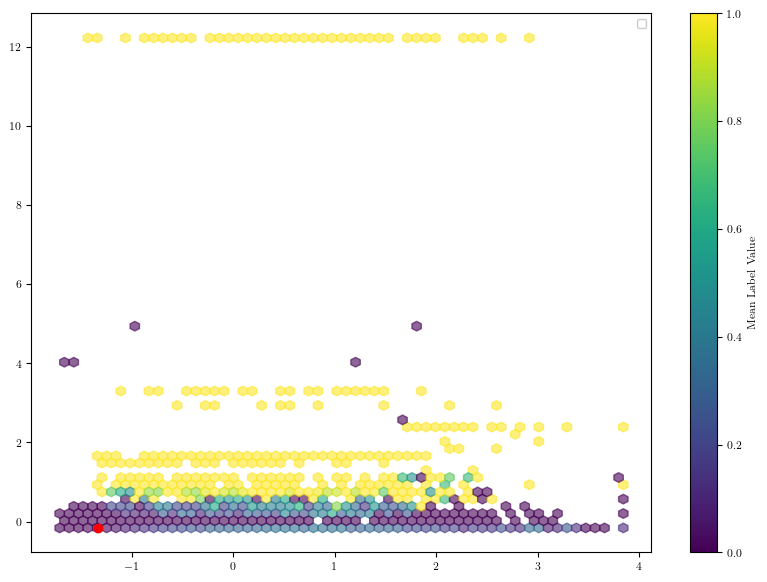

In [115]:
class ProbaLR:
    def __init__(self, model):
        self.model = model
        
    def predict_proba(self, X):
        y = self.model.predict(X)
        return y[:,None]
        

dataset, _, preprocessor = da.load_adult_income_dataset()
dataset = dataset.loc[:,['age', 'capital-gain', 'income']]
preprocessor = dp.NaivePreprocessor(categorical_features=[], continuous_features=['age', 'capital-gain'], label='income').fit(dataset)

X = preprocessor.transform(dataset.drop('income', axis=1)).copy().to_numpy()
y = dataset['income'].copy().to_numpy()
y[y == '>50K'] = 1
y[y != 1] = 0
y = y.astype('int64')

model = linear_model.LinearRegression()
model.fit(X, y)
model = ProbaLR(model)

poi = utils.random_poi(dataset, column='income', label = '<=50K')

fig, ax = Display2DPaths(
    preprocessor.transform(dataset.drop('income', axis=1)).to_numpy(),
    dataset['income'].to_numpy(),
    positive_label = '>50K'
).set_poi(preprocessor.transform_series(poi)).heatmap()

## Generate some recourse directions

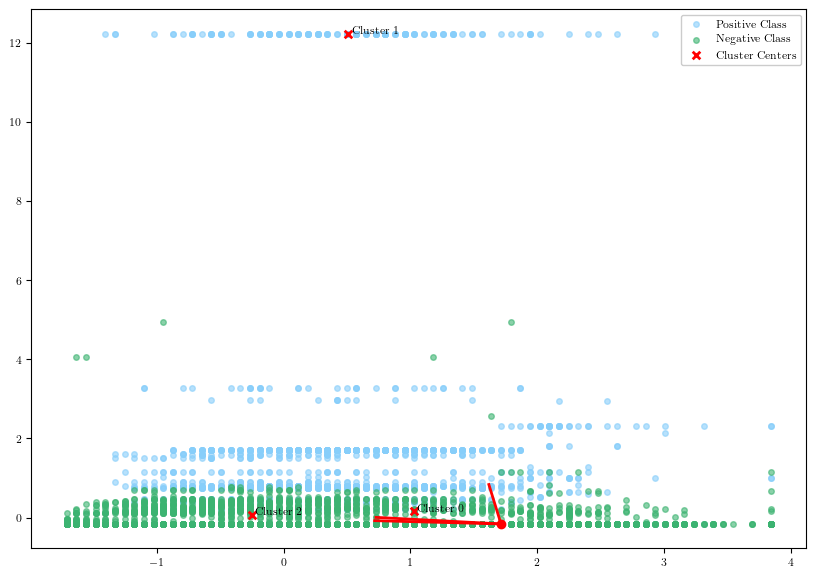

In [116]:
k_directions = 3
mrmc = mrmc_method.MRMC(
    k_directions,
    preprocessor,
    dataset,
    label_column='income',
    positive_label='>50K',
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(1))

poi = utils.random_poi(dataset, column='income', label = '<=50K')
poix = preprocessor.transform_series(poi)
dirs = mrmc.get_all_recourse_directions(poix)

fig, ax = Display2DPaths(
    preprocessor.transform(dataset.drop('income', axis=1)).to_numpy(),
    dataset['income'].to_numpy(),
    positive_label = '>50K'
).set_poi(poix).set_dirs(dirs, poix).set_clusters(mrmc.clusters.cluster_centers).scatter()

## Generate some paths
We can see that although the paths converge to the cluster, the model does not classify them positively. This is because the model is simple and does not reflect the true distribution well.

Final model certainty:
[0.27402317]


(<Figure size 1000x700 with 2 Axes>, <AxesSubplot:>)

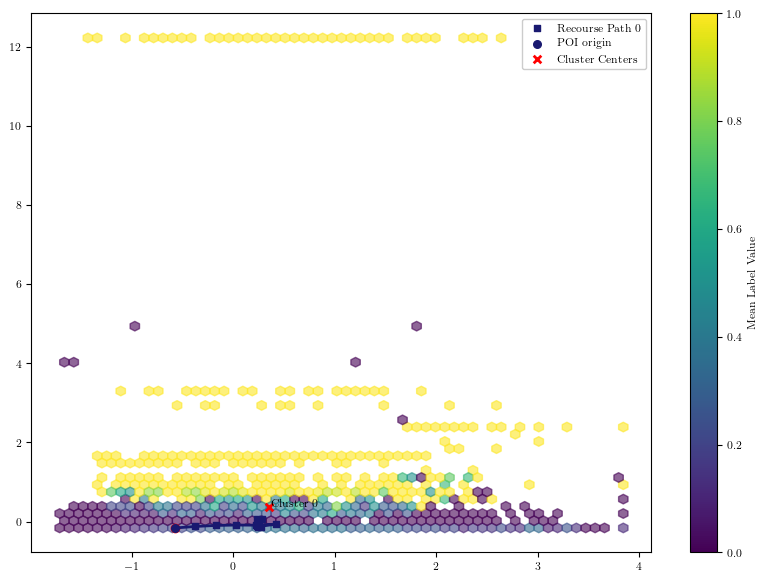

In [117]:
check_certainty = recourse_iterator.wrap_model(model, positive_index=0)

mrmc = mrmc_method.MRMC(
    1,
    preprocessor,
    dataset,
    label_column='income',
    positive_label='>50K',
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(0.2))

display = Display2DPaths(
    preprocessor.transform(dataset.drop('income', axis=1)).to_numpy(),
    dataset['income'].to_numpy(),
    positive_label = '>50K'
)

poi = utils.random_poi(dataset, column='income', label = '<=50K')

iterator = recourse_iterator.RecourseIterator(
    mrmc,
    preprocessor,
    certainty_cutoff=0.5,
    check_certainty=check_certainty)
paths = iterator.iterate_k_recourse_paths(poi, 10)

print("Final model certainty:")
print(model.predict_proba(preprocessor.transform(paths[0]).to_numpy())[-1])

transformed_paths = [preprocessor.transform(path) for path in paths]

display.set_poi(preprocessor.transform_series(poi)).set_paths(transformed_paths).set_clusters(mrmc.clusters.cluster_centers).heatmap()

## Generate paths with the model labels
Generating paths with the model labels instead of the true labels fixes this.

Final model certainty:
[0.50889306]


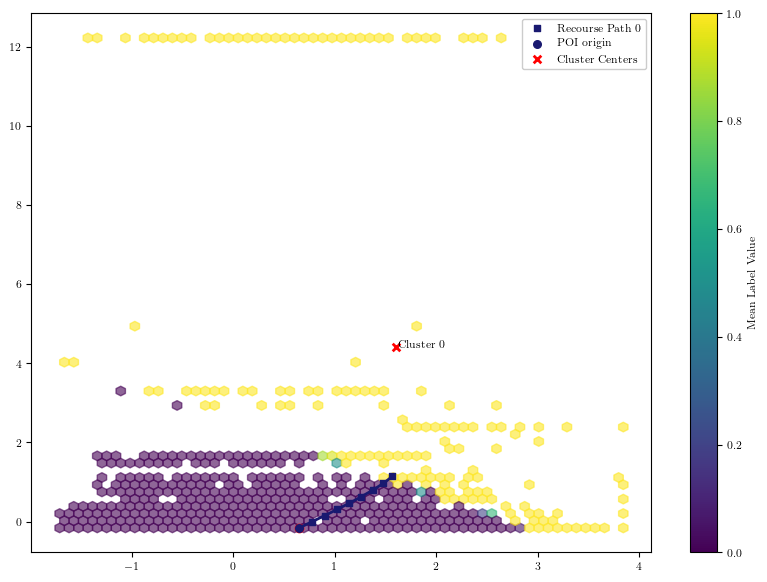

In [123]:
prob = model.predict_proba(X)
model_dataset = dataset.copy()
model_dataset.loc[:,'income'] = '<=50K'
model_dataset.loc[prob[:,0] >= 0.5,'income'] = '>50K'

poi = utils.random_poi(model_dataset, column='income', label = '<=50K')

check_certainty = recourse_iterator.wrap_model(model, positive_index=0)

mrmc = mrmc_method.MRMC(
    1,
    preprocessor,
    model_dataset,
    label_column='income',
    positive_label='>50K',
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(0.2))

poi = utils.random_poi(model_dataset, column='income', label = '<=50K')

iterator = recourse_iterator.RecourseIterator(
    mrmc,
    preprocessor,
    certainty_cutoff=0.5,
    check_certainty=check_certainty)
paths = iterator.iterate_k_recourse_paths(poi, 30)

print("Final model certainty:")
print(model.predict_proba(preprocessor.transform(paths[0]).to_numpy())[-1])

transformed_paths = [preprocessor.transform(path) for path in paths]

display = Display2DPaths(
    preprocessor.transform(dataset.drop('income', axis=1)).to_numpy(),
    model_dataset['income'].to_numpy(),
    positive_label = '>50K'
).set_poi(preprocessor.transform_series(poi)).set_paths(transformed_paths).set_clusters(mrmc.clusters.cluster_centers).heatmap()